In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.extensions.unitary import UnitaryGate
from qiskit.circuit.library.standard_gates import CZGate
from qiskit.circuit.library.standard_gates import CHGate
from qiskit.circuit.library.standard_gates import SGate

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [4]:
numLayer = 5
numQubit = 3
global iterations
global noisy

In [5]:
#Create unitaries here
#unitary_param_1 = np.array([])
#for i in range(0, 24):
#    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

unitary_param_1 = [4.76597606, 4.47050986, 4.19269861, 3.72124531, 4.94472091, 1.61563712,
                   3.44120060, 3.24526326, 0.91836107, 1.32971456, 4.80863498, 0.54593609,
                   5.49607802, 2.81204387, 3.34030218, 0.76854178, 5.53509531, 1.9704765,
                   3.75828658, 5.63981649, 0.97057624, 4.1507106 , 5.224084  , 4.39954095]

print(unitary_param_1)

[4.76597606, 4.47050986, 4.19269861, 3.72124531, 4.94472091, 1.61563712, 3.4412006, 3.24526326, 0.91836107, 1.32971456, 4.80863498, 0.54593609, 5.49607802, 2.81204387, 3.34030218, 0.76854178, 5.53509531, 1.9704765, 3.75828658, 5.63981649, 0.97057624, 4.1507106, 5.224084, 4.39954095]


In [6]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

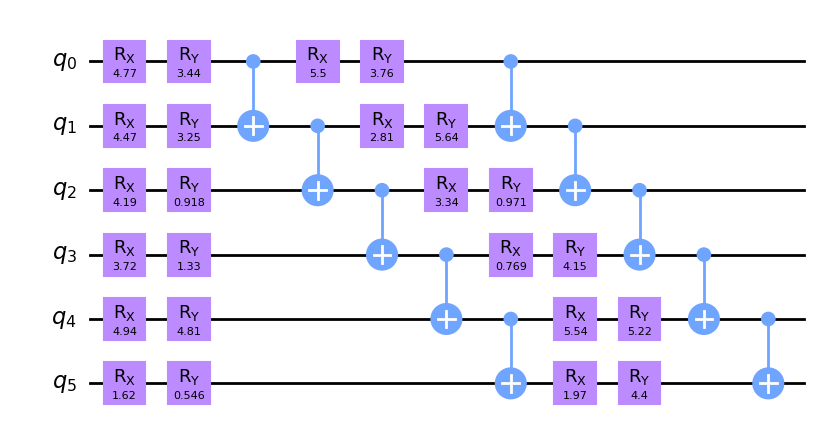

In [7]:
size = 6
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

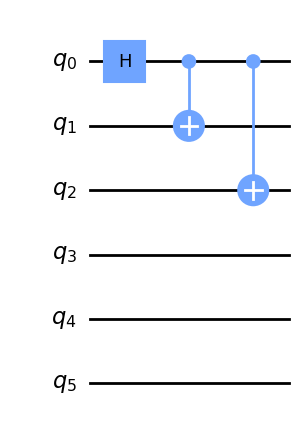

In [80]:
qcTest = QuantumCircuit(6)
#qcTest.ry(2*np.arccos(1/np.sqrt(3)), 0)
#qcTest.append(CHGate(), [0, 1])
#qcTest.cx(1, 2)
#qcTest.cx(0, 1)
#qcTest.x(0)

qcTest.h(0)
qcTest.cx(0, 1)
qcTest.cx(0, 2)
qcTest.draw('mpl')

In [81]:
def createEqSuperposQuaternion():
    temp = QuantumCircuit(2)
    temp.h(0)
    temp.h(1)
    return temp

In [82]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(8)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposQuaternion()
    circ.append(superPosCircuit, [0, 1])
    circ.append(state, [2, 3, 4, 5, 6, 7])

    prover = createProver(numQubit, numLayer)
    circ.append(prover, [5, 6, 7])
    
    circ.barrier()
    controlledU1 = SGate().control(1)
    controlledU1b = SGate().inverse().control(1)
    
    circ.append(controlledU1, [1, 2])
    circ.append(controlledU1, [1, 3])
    circ.append(controlledU1, [1, 4])
    
    circ.append(controlledU1b, [1, 5])
    circ.append(controlledU1b, [1, 6])
    circ.append(controlledU1b, [1, 7])
    
    circ.append(CZGate(), [0, 2])
    circ.append(CZGate(), [0, 3])
    circ.append(CZGate(), [0, 4])

    circ.append(CZGate(), [0, 5])
    circ.append(CZGate(), [0, 6])
    circ.append(CZGate(), [0, 7])
    
    circ.append(superPosCircuit.inverse(), [0, 1])

    return circ

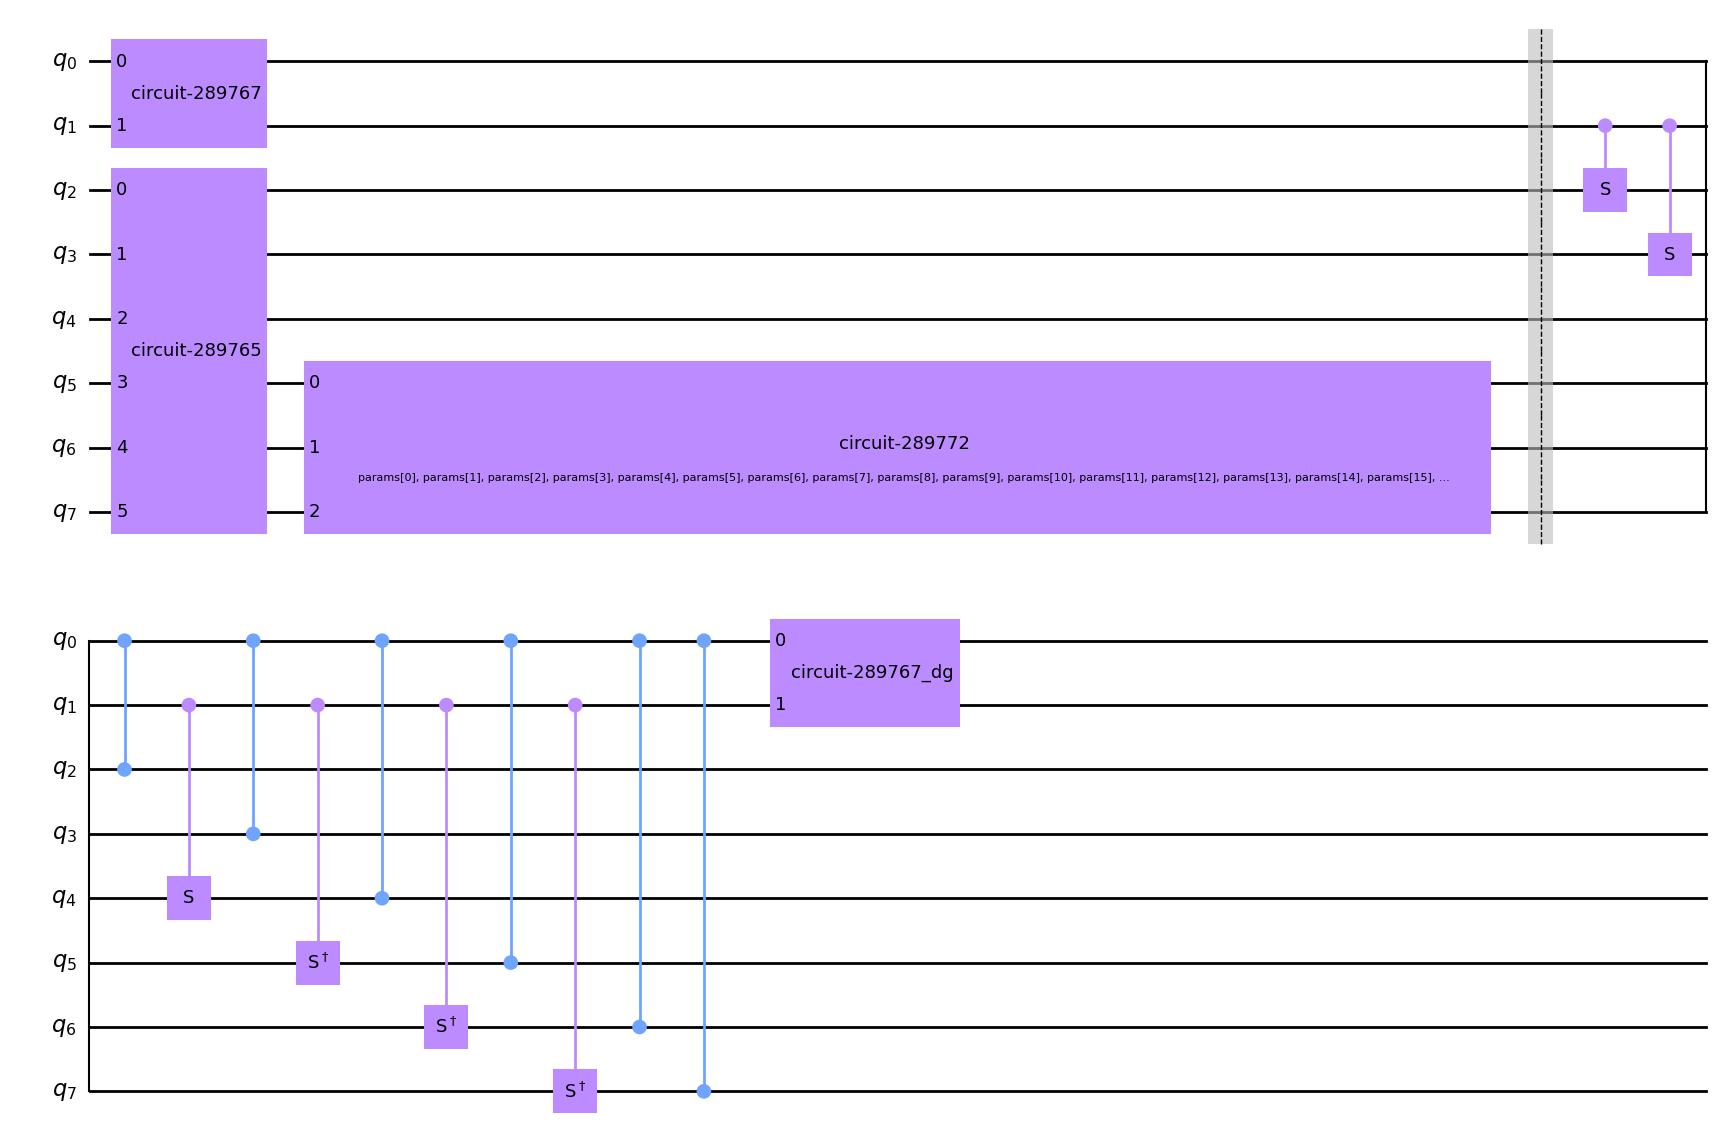

In [83]:
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [84]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [85]:
provider.backends(filters=lambda x: x.configuration().n_qubits >= 8)

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-research', group='louisiana-st-uni-1', project='main')>]

In [86]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation. 
'''
#Replace the provider with your personal credentials for hub, group and main
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [87]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [88]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [89]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [90]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17]), ParameterVectorElement(params[18]), ParameterVectorElement(params[19]), ParameterVectorElement(params[20]), ParameterVectorElement(params[21]), ParameterVectorElement(params[22]), ParameterVectorElement(params[23]), ParameterVectorElement(params[24]), ParameterVectorElement(params[25]), ParameterVectorElement(params[26]), ParameterVectorElement(

In [91]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [92]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[0.80047132 1.15334197 0.17218694 3.09904614 0.75505408 5.04323183
 0.39590632 4.38145893 5.31367535 2.37735406 5.20623956 3.98309218
 5.06982411 5.53780396 5.08767759 4.79138572 1.49863678 4.16937843
 4.50830443 1.07029779 1.6357622  1.81386049 2.97391143 2.16211781
 2.33466881 5.60792006 2.56368612 4.97392227 0.54036419 2.4518068 ]
Initial Cost :  0.03989888555358274


In [94]:
true_value = 0.5

In [95]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.03989888555358274
Loss Value :  0.18655811360628266 1.0%
Loss Value :  0.05163371151961622 2.0%
Loss Value :  0.051153793043373655 3.0%
Loss Value :  0.1671907863137987 4.0%
Loss Value :  0.15024132023350703 5.0%
Loss Value :  0.15023325489586478 6.0%
Loss Value :  0.16764719214434248 7.0%
Loss Value :  0.15995097224667662 8.0%
Loss Value :  0.17205844112500498 9.0%
Loss Value :  0.17226960219734158 10.0%
Loss Value :  0.1452758761171083 11.0%
Loss Value :  0.14528485999589275 12.0%
Loss Value :  0.22788611023870364 13.0%
Loss Value :  0.2527961454655021 14.0%
Loss Value :  0.285272719177871 15.0%
Loss Value :  0.28210318977563603 16.0%
Loss Value :  0.2794958193747574 17.0%
Loss Value :  0.2554741510022099 18.0%
Loss Value :  0.20907219226381363 19.0%
Loss Value :  0.20918896753025332 20.0%
Loss Value :  0.20966306175703484 21.0%
Loss Value :  0.22891731011819705 22.0%
Loss Value :  0.22967248135882445 23.0%
Loss Value :  0.2717660829250467 24.0%
Loss Value :  0.2712

In [ ]:
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.44873046875


In [89]:
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.4974204488032991


In [96]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
#print("Noisy : ", noisy_loss[-1])
#print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.5
Noiseless :  0.4989699626752722


In [28]:
def writeToFile():
    file = open("CZ_GS.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(true_value)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss[0:len(noiseless_loss)-1]]
    file.writelines(L)
    
    file.write(str(noiseless_loss[-1]))
    
    file.close()

In [29]:
writeToFile()